# Class Actions & Brokerage History

Often publicly traded companies experience class action lawsuits that result in settlements investors can claim if they traded or held securities issued by the defendant. Industry regulation requires brokerages to search their records and work with an associated law firm to notify qualifying investors. This query demonstrates how a brokerage might search their records for the purpose of compliance.
 
Situation: A Brokerage must search it's account and trading records to identify investors who have a claim to a class action settlement. Within the brokerage's database, account & trade data is stored within two schemas. One schema contains legacy data that’s format varies from the current schema. The brokerage's obligation is to forward qualifying investors' account number,name, and address to the associated law firm. 

Task: Build a SQL query for a tableau workbook, that with a CUSIP & time period input pulls qualifying investors' account number, name, & address. A CUSIP & time period is provided in the class action notice. Similar to a ticker symbol, a CUSIP is a nine-character alphanumeric code that identifies a financial security. 

In [ ]:
select  f.MASTER_ACCOUNT
        ,f.ACCOUNT
        ,listagg(f.RECORD, ',') WITHIN GROUP (ORDER BY f.RECORD) as RECORD
        ,f.ACCT_REGISTRATION_LINE_1
        ,f.ACCT_REGISTRATION_LINE_2
        ,f.ADDRESS
        ,f.CITY
        ,f.STATE
        ,f.ZIP
        ,f.COUNTRY
 
from (
--Search Current Account Holdings
Select Distinct
        b.MASTER_MNEMONIC as MASTER_ACCOUNT
        ,a.ACCT_NBR as ACCOUNT
        ,Case
            WHEN a.ACCT_NBR is null then 'N/A'
            else 'Held'
        END as Record
        ,b.ACCT_REGISTRATION_LINE_1
        ,b.ACCT_REGISTRATION_LINE_2
        ,b.ADDRESS_LINE1 as ADDRESS
        ,b.CITY
        ,b.STATE
        ,SUBSTR(b.ZIP,1,5) as ZIP
        ,b.COUNTRY_CD as COUNTRY
from CURRENT_SCHEMA.ACCOUNT_SECURITY_HOLDER_VW_H a left join
        CURRENT_SCHEMA.ACCOUNT_MAIN_VW b on a.ACCT_NBR = b.ACCT_NBR
where  a.SD_QTY > '0'
        and a.acct_nbr not like 'X%'
        and a.CUSIP = <Parameters.CUSIP>
        and a.ETL_EFF_DT between 'DD/MM/YYYY' and 'DD/MM/YYYY'
       
UNION
 
--Search Legacy Account Holdings
select  c.ms_br_account_top_cd as MASTER_ACCOUNT
        ,a.BR_ACCOUNT_CD as ACCOUNT
        ,Case
            WHEN a.BR_ACCOUNT_CD is null then 'N/A'
            else 'Held'
        END as Record
        ,c.NA_LINE_TXT_1
        ,c.ms_account_hldr_nm
        ,c.STREET_NM
        ,c.CITY_NM
        ,c.STATE_CD
        ,case
            when c.ZIP5_CD IS NULL then c.ZIP_FOREIGN_CD
            else c.ZIP5_CD
        end as ZIP
        ,c.COUNTRY_FOREIGN_NM
from LEGACY_SCHEMA_1.TACCOUNT_SEC_HLDR_H a left join
        LEGACY_SCHEMA_2.ACCT_NBR_XREF b on a.BR_ACCOUNT_CD = b.ACCT_NBR left join
        LEGACY_SCHEMA_1.ACCOUNT_VW c on a.BR_ACCOUNT_CD = c.BR_ACCOUNT_CD     
where  a.Settlement_Dt_Qty > '0'
        and a.br_account_cd not like '0%'
        and a.br_account_cd not like '1%'
        and a.CUSIP_INTRL_Nbr like concat(<Parameters.CUSIP>,'%')
        and a.Asof_Business_Date between 'DD/MM/YYYY' and 'DD/MM/YYYY'
UNION
 
--Search Current Trade Records
Select Distinct
        b.MASTER_MNEMONIC as MASTER_ACCOUNT
        ,a.ACCT_NBR as ACCOUNT
       ,Case
            WHEN a.ACCT_NBR is null then 'N/A'
            else 'Purchased'
        END as Record
        ,b.ACCT_REGISTRATION_LINE_1
        ,b.ACCT_REGISTRATION_LINE_2
        ,b.ADDRESS_LINE1 as ADDRESS
        ,b.CITY
        ,b.STATE
        ,SUBSTR(b.ZIP,1,5) as ZIP
        ,b.COUNTRY_CD as COUNTRY
from(
select  ACCT_NBR
        , BUY_SELL_CD
        , TRD_DT
        , NET_AMT
        , QTY
        , CUSIP
        , PRIMARY_EXEC_REP
from    CURRENT_SCHEMA.TRANS_VW_H
where   ACCT_NBR like 'T%'
        or ACCT_NBR like 'R%'
        ) a left join
    CURRENT_SCHEMA.ACCOUNT_MAIN_VW b on a.ACCT_NBR = b.ACCT_NBR
where a.buy_sell_cd = 'B'
      and a.CUSIP = <Parameters.CUSIP>
      and a.TRD_DT between 'DD/MM/YYYY' and 'DD/MM/YYYY'
 
UNION
 
--Search Legacy Trade Records
select  c.ms_br_account_top_cd as MASTER_ACCOUNT
        ,a.BR_ACCOUNT_CD as ACCOUNT
        ,Case
            WHEN a.BR_ACCOUNT_CD is null then 'N/A'
            else 'Purchased'
        END as Record
        ,c.c.NA_LINE_TXT_1
        ,c.ms_account_hldr_nm
        ,c.STREET_NM
        ,c.CITY_NM
        ,c.STATE_CD
        ,case
            when c.ZIP5_CD IS NULL then c.ZIP_FOREIGN_CD
            else c.ZIP5_CD
        end as ZIP
        ,c.COUNTRY_FOREIGN_NM
from    LEGACY_SCHEMA_1.TPRCHS_SALE_TRANS_H a left join
        LEGACY_SCHEMA_1.ACCOUNT_VW c on a.BR_ACCOUNT_CD = c.BR_ACCOUNT_CD    
where   a.br_account_cd > '19999999'
        and a.trans_acct_hist_cd = 'A'
        and a.Debit_Credit_Cd = 'D'
        and a.CUSIP_9 = <Parameters.CUSIP>
        and a.TRADE_DT between 'DD/MM/YYYY' and 'DD/MM/YYYY'
 
order by  MASTER_ACCOUNT
    ) f
group by f.MASTER_ACCOUNT
        ,f.ACCOUNT
        ,f.ACCT_REGISTRATION_LINE_1
        ,f.ACCT_REGISTRATION_LINE_2
        ,f.ADDRESS
        ,f.CITY
        ,f.STATE
       ,f.ZIP
        ,f.COUNTRY
order by f.master_account

Note the atypical syntax of <Parameters.CUSIP> , this isn't normally compatible with RDBMS's like MYSQL or Oracle SQL Developer but it allows an underlying SQL query in Tableau to reference parameter inputs from the worksheet & apply them to the query at the connection level. Utilizing this option greatly improves the speed of the Tableau workbook. 

Result: An easily accessible Tableau workbook allows a non technical user to input a CUSIP and time period form a class action notice and search company records who qualify for any claims resulting from the settlement. The Tableau workbook also conveniently display whether or not the security was held or purchased during the time period.

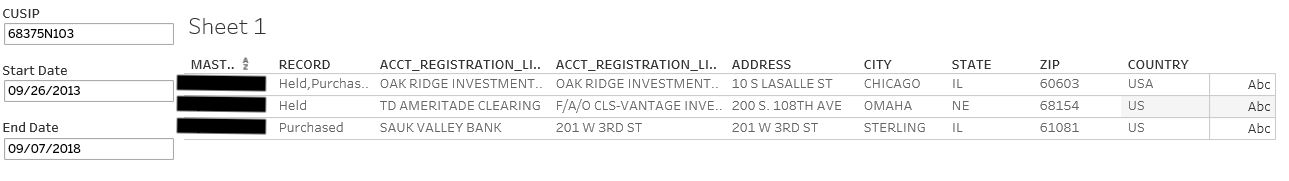